<a href="https://colab.research.google.com/github/pasquale90/mthesis/blob/master/code/initialcode/2-flatmel_esc50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Google_drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Import libraries
import os
import pandas as pd
import librosa
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm_notebook as tqdm

data_path='/content/gdrive/My Drive/dissertation/ESC-50-master/meta/'
audio_path='/content/gdrive/My Drive/dissertation/ESC-50-master/audio/'

In [ ]:
mode='80'
#mode='128'

In [ ]:
if (mode=='80'):
  featurepath='/content/gdrive/My Drive/dissertation/ESC-50-master/features/80/'
elif (mode=='128'):
  featurepath='/content/gdrive/My Drive/dissertation/ESC-50-master/features/128/'

In [ ]:
#Import Dataset
esc50 = pd.read_csv(data_path+'esc50.csv')
audiofiles = os.listdir(audio_path)
print(esc50.shape)
print(len(audiofiles))

(2000, 7)
2000


In [ ]:
#train and fold definition
#make this 5-fold
train = esc50[esc50['fold']!=5]
valid = esc50[esc50['fold']==5]

In [ ]:
def get_features(wavname):
  name=featurepath+wavname.split('.')[0]+'.png'
  image=Image.open(name)
  image=np.array(image)
  image = image/255.0 #normalize images
  return image

In [ ]:
class ESC50Data(Dataset):
  def __init__(self, df, in_col, out_col):#(train, 'filename', 'category')
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      flatmel=np.ndarray.flatten((get_features(row['filename'])))[np.newaxis,...]#(1, 55168)
      #print(flatmel.shape)
      self.data.append(flatmel)

      self.labels.append(self.c2i[row['category']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):#load data on demand
    return self.data[idx], self.labels[idx]

In [ ]:
n_out=((n_in+2*padding-kernel)/stride])+1

In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
print(device)

cpu


In [ ]:
#ESC50_MODEL_80_flatmelcnn
class  ESC50_MODEL_80_flatmelcnn(nn.Module):
    def __init__(self,input_shape, batch_size=16, num_cats=50):
        super(ESC50_MODEL_80_flatmelcnn, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU())

        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=3))
  
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        self.conv5 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        self.conv6 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3),
            nn.Dropout(0.5))

        self.conv7 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        
        self.conv8 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        # 3 x 256
        self.conv9 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        self.conv10 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU())

        self.conv11 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5))

        self.fc = nn.Linear(512, num_cats)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = x.view(x.shape[0], 1,-1 )


        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)

        x = x.view(x.shape[0], x.size(1) * x.size(2))
        x = self.fc(x)
        return x

In [ ]:
#ESC50_MODEL_128_flatmelcnn
class  ESC50_MODEL_128_flatmelcnn(nn.Module):
    def __init__(self,input_shape, batch_size=16, num_cats=50):
        super(ESC50_MODEL_128_flatmelcnn, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU())

        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=3))
  
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        self.conv5 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        self.conv6 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3),
            nn.Dropout(0.5))

        self.conv7 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        
        self.conv8 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        # 3 x 256
        self.conv9 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))

        self.conv10 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU())

        self.conv11 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5))

        self.fc = nn.Linear(512, num_cats)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = x.view(x.shape[0], 1,-1 )


        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)

        x = x.view(x.shape[0], x.size(1) * x.size(2))
        x = self.fc(x)
        return x

In [ ]:
#load flatten spectogram
train_data = ESC50Data(train, 'filename', 'category' )
valid_data = ESC50Data(valid, 'filename', 'category')

#iterate data
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

In [ ]:
#@title test_shapes
count=0
for i, data in tqdm(enumerate(valid_loader)):#performs a step in the train loop 
  a,b = data
  c=model(a.float()) #= ESC50Model(input_shape=(1,55168), batch_size=16, num_cats=50).to(device)
  count+=1
  print(a.shape)
  print(c.shape)
print(count)

In [ ]:
if (mode=='80'):
  model = ESC50_MODEL_80_flatmelcnn(input_shape=(1, 55168), batch_size=16, num_cats=50).to(device)
elif (mode=='128'):
  model = ESC50_MODEL_128_flatmelcnn(input_shape=(1, 55168), batch_size=16, num_cats=50).to(device)

In [ ]:
#CREATE AURPC METRICS
#https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265
#https://github.com/allenai/allennlp/issues/1863
loss_fn = nn.CrossEntropyLoss( )
learning_rate = 2e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)#model.parameters()is a method 
                                                            #to retrieve an iterator over all model’s parameters
                                           #Note:model.state_dict() to get the current values for all parameters
epochs = 10
train_losses = []
valid_losses = []

In [ ]:
#optimizer
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [ ]:
def lr_decay(optimizer, epoch):
  if epoch%20==0:
    new_lr = learning_rate / (10**(epoch//20))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer

In [ ]:
def train(model, loss_fn, train_loader, valid_loader,
          epochs, optimizer, train_losses, valid_losses, change_lr):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()#set the model to training mode
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in tqdm(enumerate(train_loader)):#performs a step in the train loop 
      x, y = data
      optimizer.zero_grad()#zero the gradients before updating them
      x = x.to(device, dtype=torch.float32) #init tensor _minibatch(16) of spectograms
      y = y.to(device, dtype=torch.long)  #init tensor _categories' id
      y_hat = model(x) #the equation is the model itself-,model is actually a modeled equation
      loss = loss_fn(y_hat, y)#compute forward loss
      loss.backward() #for alleviating the parameters' loss
      batch_losses.append(loss.item()) #here batch_calc is returned
      optimizer.step()#step of the optimizer-updates the parameters/  batch?mini-batch?stohastic? 
      #print(model.state_dict())
    train_losses.append(batch_losses)

    print()
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    print()
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())#allocate the tensor in RAM 
                                  #detatch --> cut computational graph
                                  #cpu --> allocate tensor in RAM
                                  #numpy --> port tensor to numpy
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)#mean of Trues
    #f1
    #micro,macro auroc
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy} ')
  return train_losses,valid_losses,accuracy,trace_y,trace_yhat,batch_losses

In [ ]:
#nmels=80
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  




Epoch - 1 Train-Loss : 3.971739103794098

Epoch - 1 Valid-Loss : 3.8615735816955565 Valid-Accuracy : 0.0325 




Epoch - 2 Train-Loss : 3.78195344209671

Epoch - 2 Valid-Loss : 3.7786248874664308 Valid-Accuracy : 0.06 




Epoch - 3 Train-Loss : 3.6229325675964357

Epoch - 3 Valid-Loss : 3.715173864364624 Valid-Accuracy : 0.065 




Epoch - 4 Train-Loss : 3.522814555168152

Epoch - 4 Valid-Loss : 3.646690845489502 Valid-Accuracy : 0.09 




Epoch - 5 Train-Loss : 3.44051500082016

Epoch - 5 Valid-Loss : 3.569822988510132 Valid-Accuracy : 0.1075 




Epoch - 6 Train-Loss : 3.328314607143402

Epoch - 6 Valid-Loss : 3.5347620105743407 Valid-Accuracy : 0.125 




Epoch - 7 Train-Loss : 3.2401233315467834

Epoch - 7 Valid-Loss : 3.42986403465271 Valid-Accuracy : 0.1275 




Epoch - 8 Train-Loss : 3.146785390377045

Epoch - 8 Valid-Loss : 3.4275429248809814 Valid-Accuracy : 0.115 




Epoch - 9 Train-Loss : 3.0550289273262026

Epoch - 9 Valid-Loss : 3.3472115802764892 Valid-Accuracy : 0.1475 




Epoch - 10 Train-Loss : 2.9832930612564086

Epoch - 10 Valid-Loss : 3.31463529586792 Valid-Accuracy : 0.1525 



([[4.140793323516846,
   4.371191024780273,
   4.035280227661133,
   4.036059379577637,
   3.7762441635131836,
   4.228168964385986,
   4.14481258392334,
   4.07410192489624,
   4.106725215911865,
   4.262150287628174,
   3.68216872215271,
   3.994494915008545,
   4.168280124664307,
   4.2682390213012695,
   3.9601573944091797,
   4.006984233856201,
   4.00408411026001,
   3.8201839923858643,
   3.89593243598938,
   4.279955863952637,
   4.19253396987915,
   3.869809150695801,
   4.082461833953857,
   3.8804826736450195,
   3.8554797172546387,
   4.0346574783325195,
   4.434213638305664,
   4.124720096588135,
   3.9993488788604736,
   3.875121593475342,
   4.089042663574219,
   3.714848518371582,
   4.046280860900879,
   4.184499740600586,
   4.023866176605225,
   4.404735565185547,
   4.022621154785156,
   3.905306577682495,
   3.8261125087738037,
   4.086616039276123,
   4.11537504196167,
   3.882146120071411,
   4.253592014312744,
   3.992161750793457,
   4.052412986755371,
   3.710

In [ ]:
#nmels=128
train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':




Epoch - 1 Train-Loss : 3.930389986038208

Epoch - 1 Valid-Loss : 3.840551986694336 Valid-Accuracy : 0.0425 




Epoch - 2 Train-Loss : 3.6844984817504884

Epoch - 2 Valid-Loss : 3.7716845417022706 Valid-Accuracy : 0.035 




Epoch - 3 Train-Loss : 3.5316851425170896

Epoch - 3 Valid-Loss : 3.695784902572632 Valid-Accuracy : 0.0625 




Epoch - 4 Train-Loss : 3.441307168006897

Epoch - 4 Valid-Loss : 3.610313377380371 Valid-Accuracy : 0.0775 




Epoch - 5 Train-Loss : 3.3027131867408754

Epoch - 5 Valid-Loss : 3.5722787761688233 Valid-Accuracy : 0.085 




Epoch - 6 Train-Loss : 3.2002388262748718

Epoch - 6 Valid-Loss : 3.556590118408203 Valid-Accuracy : 0.0975 




Epoch - 7 Train-Loss : 3.1336533427238464

Epoch - 7 Valid-Loss : 3.4710982608795167 Valid-Accuracy : 0.125 




Epoch - 8 Train-Loss : 3.0565972089767457

Epoch - 8 Valid-Loss : 3.4305038452148438 Valid-Accuracy : 0.14 




Epoch - 9 Train-Loss : 2.9415872526168823

Epoch - 9 Valid-Loss : 3.367052536010742 Valid-Accuracy : 0.12 




Epoch - 10 Train-Loss : 2.8543573451042175

Epoch - 10 Valid-Loss : 3.3259734535217285 Valid-Accuracy : 0.1575 



([[4.2816996574401855,
   4.187561988830566,
   4.080606460571289,
   4.163995265960693,
   4.0322136878967285,
   4.120812892913818,
   4.2305731773376465,
   3.847015619277954,
   3.9466536045074463,
   4.109147548675537,
   3.8216521739959717,
   4.043569564819336,
   4.193762302398682,
   3.7894859313964844,
   4.044071197509766,
   4.061855792999268,
   3.934410572052002,
   3.841013193130493,
   4.0123066902160645,
   3.7504453659057617,
   3.995096206665039,
   3.712538242340088,
   4.281787872314453,
   3.971867561340332,
   3.85929536819458,
   4.088276386260986,
   4.11299991607666,
   3.9804179668426514,
   3.993662118911743,
   3.9000511169433594,
   4.013530731201172,
   3.997713565826416,
   3.960894823074341,
   3.960214853286743,
   3.9112167358398438,
   4.127925872802734,
   3.8920462131500244,
   4.169414520263672,
   3.9114012718200684,
   3.935670852661133,
   3.9485013484954834,
   3.9184679985046387,
   3.866025686264038,
   3.799567937850952,
   3.90214085578918

# **Results**

In [ ]:
#nmels=80
Epoch - 1 Train-Loss : 3.971739103794098
Epoch - 1 Valid-Loss : 3.8615735816955565 Valid-Accuracy : 0.0325 

Epoch - 2 Train-Loss : 3.78195344209671
Epoch - 2 Valid-Loss : 3.7786248874664308 Valid-Accuracy : 0.06 

Epoch - 3 Train-Loss : 3.6229325675964357
Epoch - 3 Valid-Loss : 3.715173864364624 Valid-Accuracy : 0.065 

Epoch - 4 Train-Loss : 3.522814555168152
Epoch - 4 Valid-Loss : 3.646690845489502 Valid-Accuracy : 0.09 

Epoch - 5 Train-Loss : 3.44051500082016
Epoch - 5 Valid-Loss : 3.569822988510132 Valid-Accuracy : 0.1075 

Epoch - 6 Train-Loss : 3.328314607143402
Epoch - 6 Valid-Loss : 3.5347620105743407 Valid-Accuracy : 0.125 

Epoch - 7 Train-Loss : 3.2401233315467834
Epoch - 7 Valid-Loss : 3.42986403465271 Valid-Accuracy : 0.1275 

Epoch - 8 Train-Loss : 3.146785390377045
Epoch - 8 Valid-Loss : 3.4275429248809814 Valid-Accuracy : 0.115 

Epoch - 9 Train-Loss : 3.0550289273262026
Epoch - 9 Valid-Loss : 3.3472115802764892 Valid-Accuracy : 0.1475 

Epoch - 10 Train-Loss : 2.9832930612564086
Epoch - 10 Valid-Loss : 3.31463529586792 Valid-Accuracy : 0.1525 



#128 
Epoch - 1 Train-Loss : 3.930389986038208
Epoch - 1 Valid-Loss : 3.840551986694336 Valid-Accuracy : 0.0425 

Epoch - 2 Train-Loss : 3.6844984817504884
Epoch - 2 Valid-Loss : 3.7716845417022706 Valid-Accuracy : 0.035 

Epoch - 3 Train-Loss : 3.5316851425170896
Epoch - 3 Valid-Loss : 3.695784902572632 Valid-Accuracy : 0.0625 

Epoch - 4 Train-Loss : 3.441307168006897
Epoch - 4 Valid-Loss : 3.610313377380371 Valid-Accuracy : 0.0775 

Epoch - 5 Train-Loss : 3.3027131867408754
Epoch - 5 Valid-Loss : 3.5722787761688233 Valid-Accuracy : 0.085 

Epoch - 6 Train-Loss : 3.2002388262748718
Epoch - 6 Valid-Loss : 3.556590118408203 Valid-Accuracy : 0.0975 

Epoch - 7 Train-Loss : 3.1336533427238464
Epoch - 7 Valid-Loss : 3.4710982608795167 Valid-Accuracy : 0.125 

Epoch - 8 Train-Loss : 3.0565972089767457
Epoch - 8 Valid-Loss : 3.4305038452148438 Valid-Accuracy : 0.14 

Epoch - 9 Train-Loss : 2.9415872526168823
Epoch - 9 Valid-Loss : 3.367052536010742 Valid-Accuracy : 0.12 

Epoch - 10 Train-Loss : 2.8543573451042175
Epoch - 10 Valid-Loss : 3.3259734535217285 Valid-Accuracy : 0.1575 

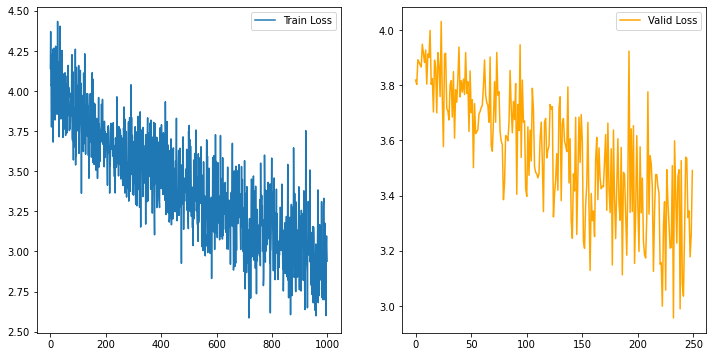

In [ ]:
#flatmel 80 10 epoch
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

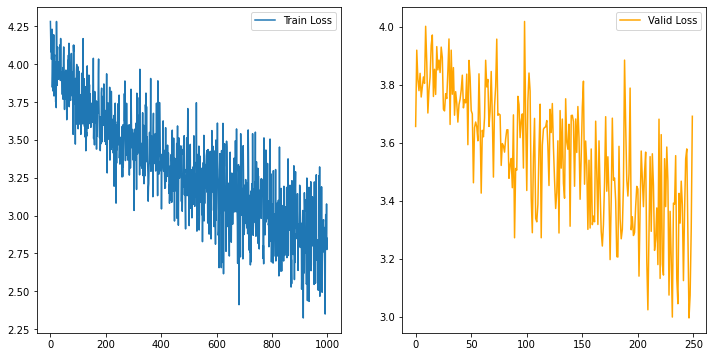

In [ ]:
#flatmel 128 10 epoch
tl = np.asarray(train_losses).ravel()
vl = np.asarray(valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])

In [ ]:
with open('/content/gdrive/My Drive/dissertation/models/22.ESC50_MODEL_128_flatmelcnn.pth','wb') as f:
  torch.save(ESC50_MODEL_128_flatmelcnn, f)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ESC50_MODEL_128_flatmelcnn. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
import pickle
with open('/content/gdrive/My Drive/dissertation/models/data/22.esc50_flatmel_128.pkl','wb') as f:
  pickle.dump(train_data.i2c, f)